# Graph Neural Networks for Small Molecule Regression
_by David Holmberg (August 2023)_
#### Dataset
For this exercise we will use a dataset of aqueous solubility for 1142 diverse chemical compounds.

#### Modelling comparisons
We will be doing a little bit of comparison between classical machine learning methods Support Vectort Machines and Random Forest to those of Graph Neural Networks

#### Aims
* Introduce the concept of Graph Neural Networks
* Introduce PyTorch code for GNNs


## Load packages
First we load the packags that we are going to be using:

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Pytorch and Pytorch Geometric
import torch as tch
import torch.nn as nn
import torch.optim as optim

from torch_geometric.nn import GCNConv, GATConv, summary as gsummary, global_mean_pool, global_max_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import dropout_adj

from rdkit import Chem
from rdkit.Chem import AllChem


# Helper libraries
from torchsummary import summary as asummary
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import os


device = tch.device("cuda" if tch.cuda.is_available() else "cpu")


RDKit WARNING: [09:22:37] Enabling RDKit 2019.09.1 jupyter extensions
[09:22:37] Enabling RDKit 2019.09.1 jupyter extensions


## Functions
Next we define som utility functions that will be used in the lab:

In [2]:


def plot_history(train_losses, val_losses, model_name):
    fig = plt.figure(figsize=(15, 5), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(train_losses)
    ax.plot(val_losses)
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Train', 'Test'], loc='upper right')
    ax = fig.add_subplot(122)
    ax.plot(np.log(train_losses))
    ax.plot(np.log(val_losses))
    ax.set(title=model_name + ': Log model loss', ylabel='Log loss', xlabel='Epoch')
    ax.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    plt.close()
#Set morgan to 3 or 4 and nBits to 1024
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    return list(fp.ToBitString())

def smiles_to_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    # if mol is not None:
    #     mol = Chem.AddHs(mol)
    return mol

def read_smiles_data(path_data):
    df = pd.read_csv(path_data, sep=',')
    df['fingerprint'] = df['SMILES'].apply(smiles_to_fingerprint)
    df['fingerprint'] = df['fingerprint'].apply(lambda x: [int(bit) for bit in x])
    df['fingerprint'] = df['fingerprint'].apply(lambda x: np.array(x))
    df['mol'] = df['SMILES'].apply(smiles_to_mol)
    return df

def is_hydrogen_donor(atomic_num, hybridization):
    return int((atomic_num == 8 or atomic_num == 7) and (hybridization == 3 or hybridization == 2))

def is_polar_bond(atom1_num, atom2_num, electronegativity):
    en1 = electronegativity.get(atom1_num, None)
    en2 = electronegativity.get(atom2_num, None)
    if en1 is None or en2 is None:
        return 0  # Unknown electronegativity, consider as non-polar
    return int(abs(en1 - en2) > 0.4)

def electroneg():
    return {
    1: 2.20,  # H
    3: 0.98,  # Li
    4: 1.57,  # Be
    5: 2.04,  # B
    6: 2.55,  # C
    7: 3.04,  # N
    8: 3.44,  # O
    9: 3.98,  # F
    11: 0.93, # Na
    12: 1.31, # Mg
    13: 1.61, # Al
    14: 1.90, # Si
    15: 2.19, # P
    16: 2.58, # S
    17: 3.16, # Cl
    19: 0.82, # K
    20: 1.00, # Ca
    22: 1.54, # Ti
    24: 1.66, # Cr
    25: 1.55, # Mn
    26: 1.83, # Fe
    27: 1.88, # Co
    28: 1.91, # Ni
    29: 1.90, # Cu
    30: 1.65, # Zn
    35: 2.96, # Br
    53: 2.66, # I
}

def weights_init(m):
    if isinstance(m, (GCNConv, GATConv)):
        nn.init.xavier_uniform_(m.weight.data)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)

def make_pyg(row):
    # Create node features
    mol = row['mol']
    # pauling = electroneg()
    atom_num = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    atom_hyb = [int(atom.GetHybridization()) for atom in mol.GetAtoms()]
    atom_deg = [atom.GetDegree() for atom in mol.GetAtoms()]
    atom_arom = [int(atom.GetIsAromatic()) for atom in mol.GetAtoms()]  # Aromaticity
    atom_hydrogens = [atom.GetTotalNumHs() for atom in mol.GetAtoms()]  # Number of hydrogens
    # atom_h_donor = [is_hydrogen_donor(num, hyb) for num, hyb in zip(atom_num, atom_hyb)]
    atom_charge = [atom.GetFormalCharge() for atom in mol.GetAtoms()]  # Formal charge
    atom_chiral_tag = [int(atom.GetChiralTag()) for atom in mol.GetAtoms()]  # Chirality
    atom_val = [atom.GetExplicitValence() for atom in mol.GetAtoms()]
    #atom_mass = [atom.GetMass() for atom in mol.GetAtoms()]
    #atom_pauling = [pauling.get(num, 0) for num in atom_num]
    
    x1 = tch.tensor(atom_num, dtype=tch.float).view(-1, 1)
    x2 = tch.tensor(atom_hyb, dtype=tch.float).view(-1, 1)
    x3 = tch.tensor(atom_deg, dtype=tch.float).view(-1, 1)
    x4 = tch.tensor(atom_arom, dtype=tch.float).view(-1, 1)
    x5 = tch.tensor(atom_hydrogens, dtype=tch.float).view(-1, 1)
    x6 = tch.tensor(atom_charge, dtype=tch.float).view(-1, 1)
    x7 = tch.tensor(atom_chiral_tag, dtype=tch.float).view(-1, 1)
    x8 = tch.tensor(atom_val, dtype=tch.float).view(-1, 1)
    # x9 = tch.tensor(atom_h_donor, dtype=tch.float).view(-1, 1)
    #x10 = tch.tensor(atom_mass, dtype=tch.float).view(-1, 1)
    #x11 = tch.tensor(atom_pauling, dtype=tch.float).view(-1, 1)
    
    y = tch.tensor(row['measured.log.solubility.mol.L.'], dtype=tch.float).view(-1, 1)
    x = tch.cat([x1
                 , x2
                 , x3
                 , x4
                 , x5
                 , x6
                 , x7
                 , x8
                # , x9
                # , x10
                 #, x11
                 ], dim=1)
    
    # Create edge features (connectivity)
    edge_indices = []
    edge_features = []
    
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_indices.append((i, j))
        bond_type = bond.GetBondTypeAsDouble()
        is_conjugated = int(bond.GetIsConjugated())  # Conjugation
        is_in_ring = int(bond.IsInRing())  # Ring membership
        bond_stereo = int(bond.GetStereo())  # Stereo configuration
        #bond_polarity = is_polar_bond(atom_num[i], atom_num[j], pauling)

        edge_features.append([bond_type
                              , is_conjugated
                              , is_in_ring
                              , bond_stereo
                              #, bond_polarity
                              ])
    
    edge_index = tch.tensor(edge_indices, dtype=tch.long).t().contiguous()
    edge_attr = tch.tensor(edge_features, dtype=tch.float)
    
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

    data.smiles = row['SMILES']
    
    return data


### Training Functions for Neural Networks
This cell defines the training methods for the neural networks you will use later in this notebook. Here we can see what parameters are used when training the models, we have:
 * gnn1_model -- the model that we are going to train
 * t_loader -- PyTorch specific helper for loading training data
 * v_loader -- PyTorch specific helper for loading test (validation) data
 * num_epochs -- the number of epochs to train. The higher the number the longer we will train
 * batch_size -- training is done in batches. Higher number means faster training, lower number can give higher precission
 * optimizer -- the optimization algorithm to be used. These days often som variant of Adam is used which also controls the learning rate automaticly during runtime

In [3]:
def fitGNN(gnn1_model, t_loader, v_loader, num_epochs, batch_size, optimizer, criterion):
    train_losses = []
    val_losses = []
    pbar = tqdm(range(num_epochs), desc="Epochs")
    pbar.reset()
    pbar_t = tqdm(total=len(t_loader), desc="Training Batch:", leave=False)
    pbar_v = tqdm(total=len(v_loader), desc="validation Batch:", leave=False)
    for epoch in range(num_epochs):
        # Training Phase
        gnn1_model.train()
        train_loss_items = []
        pbar_t.reset()
        pbar_v.reset()
        for batch in t_loader:
            batch.to(device)
            optimizer.zero_grad()
            # Use Batch Data object in forward pass
            outputs = gnn1_model(batch.x.float(), batch.edge_index, batch.batch)
            loss = criterion(outputs, batch.y)
            loss.backward()
            optimizer.step()
            train_loss_items.append(loss.item())
            pbar_t.update()
        avg_train_loss = sum(train_loss_items) / len(train_loss_items)
        train_losses.append(avg_train_loss)
        # Validation Phase (assuming you have a separate validation loader)
        gnn1_model.eval()
        val_loss_items = []
        with tch.no_grad():
            for val_batch in v_loader:
                val_batch.to(device)
                val_outputs = gnn1_model(val_batch.x.float(), val_batch.edge_index, val_batch.batch)
                val_loss = criterion(val_outputs, val_batch.y)
                val_loss_items.append(val_loss.item())
                pbar_v.update()

        avg_val_loss = sum(val_loss_items) / len(val_loss_items)
        val_losses.append(avg_val_loss)
        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Val Loss: {avg_val_loss:.4f}')
        pbar.update(1)
        pbar.set_postfix({"Training Loss": avg_train_loss, "Validation Loss": avg_val_loss})
    return gnn1_model, train_losses, val_losses

## Load and preprocess data


#### Load and check shape of X and y
We load our data from the file solubility.csv and take a quick look at it.

In [4]:
df = read_smiles_data('data/solubility.csv')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()


,Compound.ID,measured.log.solubility.mol.L.,ESOL.predicted.log.solubility.mol.L.,SMILES,fingerprint,mol
0,"2,3,6-Trichlorophenol",-2.64,-3.572,Oc1c(Cl)ccc(Cl)c1Cl,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f2d2ddf1820>
1,tetrachloroguaiacol,-4.02,-4.299,COc1c(O)c(Cl)c(Cl)c(Cl)c1Cl,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f2d2dd8b760>
2,3-Methyl-3-heptanol,-1.60,-2.017,CCCCC(C)(O)CC,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f2d2ddeeac0>
3,cycloheximide,-1.13,-1.532,CC1CC(C)C(=O)C(C1)C(O)CC2CC(=O)NC(=O)C2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f2d2dde88e0>
4,Acridine,-3.67,-3.846,c3ccc2nc1ccccc1cc2c3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f2d2ddec7c0>


#### Cleaning and housekeeping
These lines remove an empty row from the dataset and creates a PyG Graph object for the GNN 

In [5]:
data_pyg = df.apply(make_pyg, axis=1)
data_pyg = data_pyg[data_pyg.apply(lambda x: len(x.edge_index.shape) != 1)]
data_pyg.reset_index(drop=True, inplace=True)


#### Split into training and test sets and standardize the data
We will make a simple train / test set split. Better might be to do cross validation but it would also take longer time to run.

In [6]:
df_train = df.sample(frac=0.7)
df_test = df.drop(df_train.index)

df_train.reset_index(drop=True)
df_test.reset_index(drop=True)
X_train, y_train = df_train['fingerprint'].tolist(), df_train['measured.log.solubility.mol.L.'].tolist()
X_test, y_test = df_test['fingerprint'].tolist(), df_test['measured.log.solubility.mol.L.'].tolist()

n_train = int(len(data_pyg) * 0.7) # 70% of data for training and 30% for testing
indices = np.arange(n_train)
data_train = data_pyg[indices[:n_train]]
data_train.reset_index(drop=True, inplace=True)
data_test = data_pyg[~data_pyg.isin(data_train)]
data_test.reset_index(drop=True, inplace=True)


## Random Forest Regressor & Support Vector Regressor
For comparative purposes we will build a Random Forest and a Support Vector model. For these machine learning algorithms we will just use the default hyper parameter settings, which are often a good place to start. This means that we will just have ampty () after the model definition. To change the hyper parameters from the defaults one needs to specify them within the braces.

#### Random Forest Regressor

In [7]:
RF_model = RandomForestRegressor()
RF_model.fit(X_train, y_train)
RF_pred = RF_model.predict(X_test)
RF_mse = mean_squared_error(y_test, RF_pred)
print('Random Forest Regressor: MSE = ' + str(np.round(RF_mse, 3)))

Random Forest Regressor: MSE = 1.375


#### Support Vector Regressor

In [8]:
SV_model = SVR()
SV_model.fit(X_train, y_train)
SV_pred = SV_model.predict(X_test)
SV_mse = mean_squared_error(y_test, SV_pred)
print('Support Vector Regressor: MSE = ' + str(np.round(SV_mse, 3)))

Support Vector Regressor: MSE = 1.56


### Testing GNNs
So, now we have tested regression on molecular descriptors with the two classical machine learning algorithms random forest and support vector machines. Another option that is gaining traction in the research world is using Graph Neural Networks. We will be using an extension library called Pytorch.Geometric for this. There are two cannonical implementations for GNNs - one being Graph Convolutional Networks and the other being Graph Attention Networks. We will try both here. Below you will find two pre-implemented GNNs, one of each type. 

### Testing GNNs
So, now we have tested regression on molecular descriptors with the two classical machine learning algorithms random forest and support vector machines. Another option that is gaining traction in the research world is using Graph Neural Networks. We will be using an extension library called Pytorch.Geometric for this. There are two cannonical implementations for GNNs - one being Graph Convolutional Networks and the other being Graph Attention Networks. We will try both here. Below you will find two pre-implemented GNNs, one of each type. 

First we define some training parameters that will be shared among both models:

In [9]:
input_dim = data_train.iloc[5].x.size(1)
print('Input Dimensions: ', input_dim)
#Loss, Epochs, Batch-size
num_epochs = 600
batch_size = 64
weight_decay = 1e-4
criterion = nn.MSELoss()
#Data Loaders to handle the graphs we made earlier
t_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
v_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)

Input Dimensions:  8


Next we define the actual GNN layers. First we will do the convolutional GNN

In [10]:
class GNN_conv(nn.Module):
    def __init__(self, input_dim):
        super(GNN_conv, self).__init__()
        self.conv1 = GCNConv(input_dim, 32)
        self.conv2 = GCNConv(32, 64)
        self.conv3 = GCNConv(64, 16)
        self.fc3 = nn.Linear(16, 1)  # Output layer with 1 node
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, edge_index, batch):
        x = self.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = self.relu(self.conv3(x, edge_index))
        x = self.dropout(x)
        x = global_mean_pool(x, batch)
        x = self.fc3(x)
        return x
    

Then we train it: (This step takes a little while to run)

In [11]:
gnn_conv_model = GNN_conv(input_dim)
gnn_conv_model = gnn_conv_model.to(device)
# Adam adjusts learning rate as needed
optimizer = optim.Adam(gnn_conv_model.parameters(), lr=0.0001,weight_decay= weight_decay)
#Traing the Model
gnn_conv_model, train_losses, val_losses = fitGNN(gnn_conv_model, t_loader, v_loader, num_epochs, batch_size, optimizer, criterion)

Epochs:   0%|          | 0/600 [00:00<?, ?it/s]

Training Batch::   0%|          | 0/13 [00:00<?, ?it/s]

validation Batch::   0%|          | 0/6 [00:00<?, ?it/s]

And finally we make a plot showing how the training has progressed:

Convolutional GNN Regression: MSE = 3.343


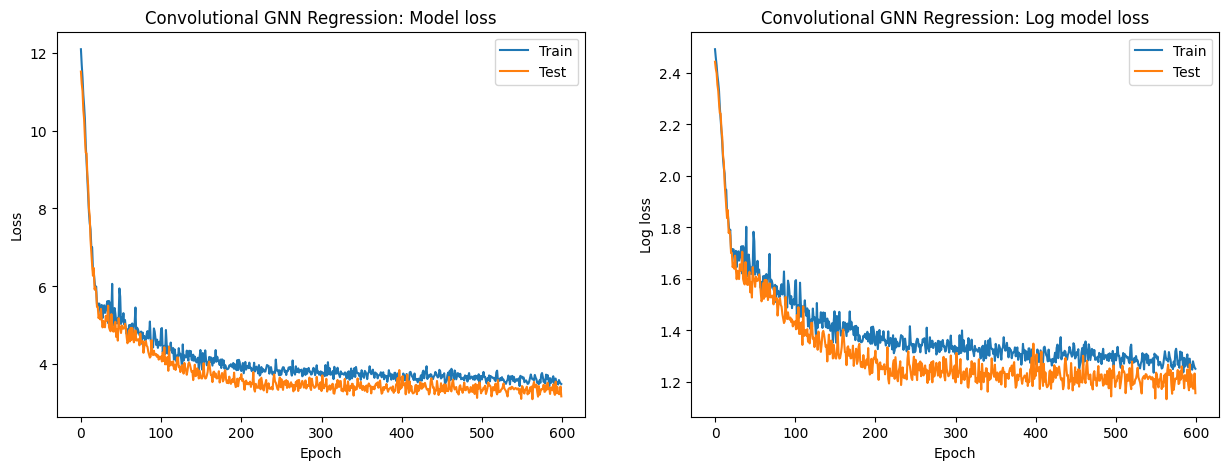

In [12]:
gnn_conv_model.eval()
all_preds = []
all_labels = []
with tch.no_grad():
    for v_batch in v_loader:
        v_batch.to(device)
        test_outputs = gnn_conv_model(v_batch.x, v_batch.edge_index, v_batch.batch)
        all_preds.extend(test_outputs.tolist())
        all_labels.extend(v_batch.y.tolist())
all_preds_tensor = tch.tensor(all_preds)
all_labels_tensor = tch.tensor(all_labels)
gnn_conv_mse = mean_squared_error(all_labels_tensor, all_preds_tensor)

print(f'Convolutional GNN Regression: MSE = {gnn_conv_mse:.3f}')
plot_history(train_losses, val_losses, 'Convolutional GNN Regression')

Next we will do the attention based GNN. First we define the layers of the network:

In [13]:

class GNN_atten(nn.Module):
    def __init__(self, input_dim):
        super(GNN_atten, self).__init__()
        self.conv1 = GATConv(input_dim, 32, heads=1, concat=True)  # Two attention heads
        self.conv2 = GATConv(32, 32, heads=2, concat=True)  # Two attention heads
        self.conv3 = GATConv(64, 8, heads=2, concat=True)  # Two attention heads
        self.fc3 = nn.Linear(16, 1)  # Output layer with 1 node
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x, edge_index, batch):
        x = self.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = self.relu(self.conv3(x, edge_index))
        x = self.dropout(x)
        x = global_mean_pool(x, batch)
        x = self.fc3(x)
        return x

Then we train the network. Again, this step will take a little while.

In [14]:
gnn_atten_model = GNN_atten(input_dim).to(device)
optimizer = optim.Adam(gnn_atten_model.parameters()
                       , lr=0.001
                    #    , weight_decay= weight_decay
                       ) 
gnn2_model, train_losses, val_losses = fitGNN(gnn_atten_model, t_loader, v_loader, num_epochs, batch_size, optimizer, criterion)

Epochs:   0%|          | 0/600 [00:00<?, ?it/s]

Training Batch::   0%|          | 0/13 [00:00<?, ?it/s]

validation Batch::   0%|          | 0/6 [00:00<?, ?it/s]

And we make a plot for this model as well

Attention GNN Regression: MSE = 1.506


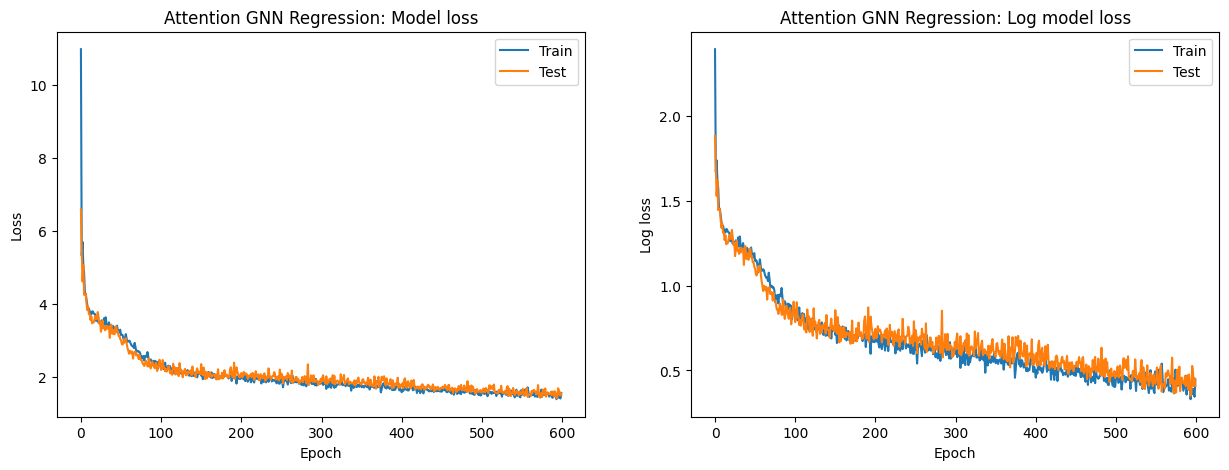

In [15]:
gnn_atten_model.eval()
all_preds = []
all_labels = []
with tch.no_grad():
    for v_batch in v_loader:
        v_batch.to(device)
        test_outputs = gnn_atten_model(v_batch.x, v_batch.edge_index, v_batch.batch)
        all_preds.extend(test_outputs.tolist())
        all_labels.extend(v_batch.y.tolist())
all_preds_tensor = tch.tensor(all_preds)
all_labels_tensor = tch.tensor(all_labels)
gnn_atten_mse = mean_squared_error(all_labels_tensor, all_preds_tensor)

print(f'Attention GNN Regression: MSE = {gnn_atten_mse:.3f}')
plot_history(train_losses, val_losses, 'Attention GNN Regression')

## Result
Finally we make a plot of the results for the different methods:

Text(0.5, 1.0, 'Results from the lab')

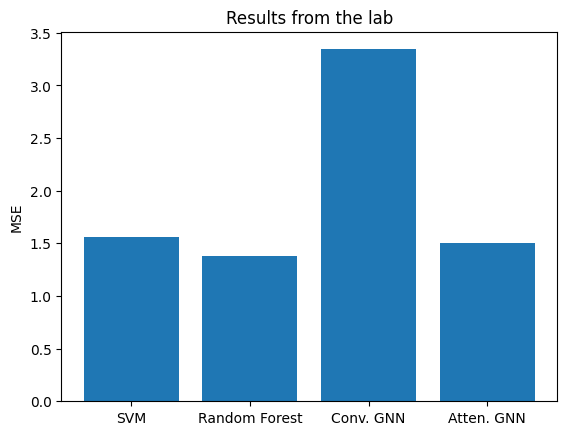

In [16]:
plt.bar(["SVM", "Random Forest", "Conv. GNN", "Atten. GNN"], [SV_mse, RF_mse, gnn_conv_mse, gnn_atten_mse])
plt.ylabel("MSE")
plt.title("Results from the lab")

Now, on the x axis we list the four models we have built and on the y axis we have MSE (so lower values are better).

So, you results should be that the convolutional GNN performs the worst (probably that method is just not very good for this kind of data) and the classical machine learning methods should perform about the same as the attention based GNN. Notice that we ran just default values for SVM and RF so there is probably room for some improvement with them but they were in this case much quicker.

The deep learning approach benefits from large amounts of compute. We can see from the plots that the GNNs could benefit from further training. 